![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/05/logo-upv-horizontal.png)
![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/06/logos-perte-chip-1024x119.png)


# Laboratory 5. Interferometers - Ring Resonator

In this session we will analyze the behaviour of a Ring Resonator filter and we will develope the design flow.

Import libraries

In [1]:
import gdsfactory as gf
import numpy as np
import sax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import gplugins.tidy3d as gt
import gplugins.sax as gs

from gdsfactory.generic_tech import get_generic_pdk
from gplugins.common.config import PATH
from functools import partial

##1. RR modeling
### 1.1 . **NUMERICAL SIMULATION**. Let's compute the transfer function of a Ring Resonator.

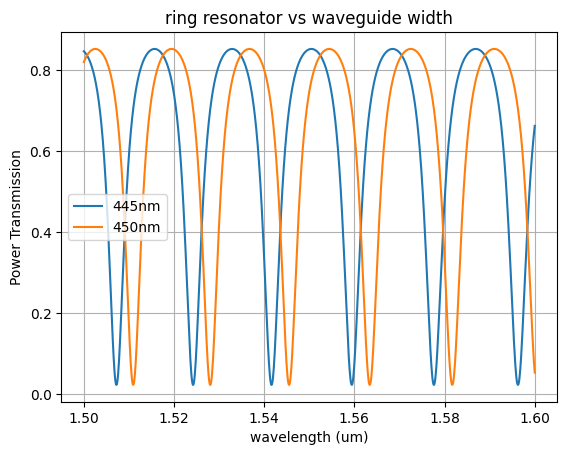

In [2]:
#Function definition - RR
def ring(
    wvl: np.ndarray,
    wvl0: float,
    neff: float,
    ng: float,
    l_ring: float,
    k: float,
    alpha: float,

) -> np.ndarray:
    """Returns Frequency Domain Response of an all pass filter.

    Args:
        wvl: wavelength in um.
        wvl0: center wavelength at which neff and ng are defined.
        neff: effective index.
        ng: group index.
        L_ring: ring length in um.
        k: coupling coefficient
        alpha: losses
    """
    neff_wvl = (
        neff + (wvl0 - wvl) * (ng - neff) / wvl0
    )  # we expect a linear behavior with respect to wavelength

    beta = (2*np.pi*neff_wvl/wvl)-1j*alpha/2

    kappa = np.sqrt(k);
    t = np.sqrt(1-k);
    gamma = t+kappa;

    # General case:
    # hr = ((1-gamma)-np.sqrt((1-gamma)*(1-k))*np.exp(1j*beta*l_ring))/(np.sqrt((1-gamma)*(1-k))-np.exp(1j*beta*l_ring))

    # Case 1: Gamma = 0 (no excess losses), alpha non 0
    A = np.sqrt(1-k);
    hr = (1/A)*(1 - A*np.exp(alpha*l_ring/2)*np.exp(1j*2*np.pi*neff_wvl*l_ring/wvl)) / (1 - (1/A)*np.exp(alpha*l_ring/2)*np.exp(1j*2*np.pi*neff_wvl*l_ring/wvl))

    return abs(hr)**2


# Simulation Parameters

alpha = 0.03  # waveguide loss
neff = 2.35577  # Effective index of the waveguides
wvl0 = 1.55  # [μm] the wavelength at which neff and ng are defined
radius = 5 # [μm] RR radius
l_ring = 2 * np.pi * radius  # [μm] Length of the ring
k = 0.5  # [] coupling of the coupler
wvl = np.linspace(1.5, 1.6, 1000)  # [μm] Wavelengths to sweep over
thickness = 220
widths = np.array([0.445, 0.45])
neffs = np.array([2.34488, 2.35577])
ng = 4.3  # Group index of the waveguides

for width, neff in zip(widths, neffs):
    p = ring(
        wvl=wvl,
        wvl0=wvl0,
        neff=neff,
        ng=ng,
        l_ring=l_ring,
        k=k,
        alpha=alpha,
    )
    plt.plot(wvl, p, label=f"{int(width*1e3)}nm")

plt.title("ring resonator vs waveguide width")
plt.xlabel("wavelength (um)")
plt.ylabel("Power Transmission")
plt.grid()
plt.legend()
plt.show()

Let's play a bit :)

**Assessment 1.**
*1.1.* What happen when changing the value of the n_g (group index)?
*1.2.* How does propagation loss influence the response of the RR?


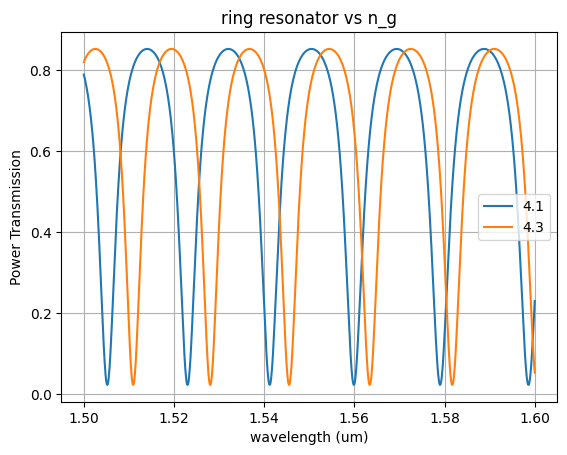

In [3]:
ngs = [4.1, 4.3, 4.5]  # Group index of the waveguides

for ng, neff in zip(ngs, neffs):
    p = ring(
        wvl=wvl,
        wvl0=wvl0,
        neff=neff,
        ng=ng,
        l_ring=l_ring,
        k=k,
        alpha=alpha,
    )
    plt.plot(wvl, p, label=f"{ng}")

plt.title("ring resonator vs n_g")
plt.xlabel("wavelength (um)")
plt.ylabel("Power Transmission")
plt.grid()
plt.legend()
plt.show()

Let's play a bit :)

1) What does it happen when changing the value of the n_g (group index)?
2) How does propagation loss influence the response of the RR?

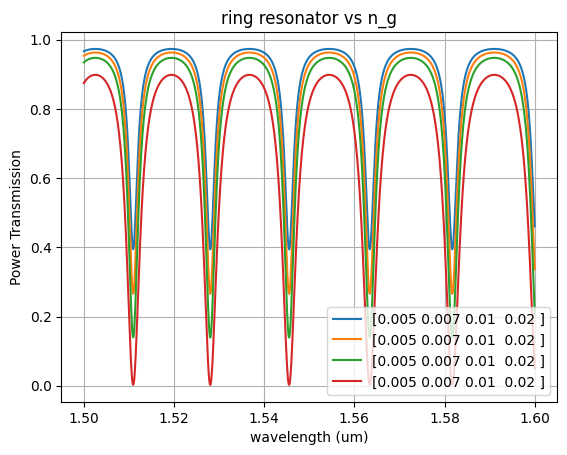

In [4]:
ng = 4.3

loss = np.array([0.005, 0.007, 0.01, 0.02])
# EXERCISE : Translate natural units to dB/um units

for alpha in loss:
    p = ring(
        wvl=wvl,
        wvl0=wvl0,
        neff=neff,
        ng=ng,
        l_ring=l_ring,
        k=k,
        alpha = alpha,
    )

    plt.plot(wvl, p, label=f"{loss}")

plt.title("ring resonator vs n_g")
plt.xlabel("wavelength (um)")
plt.ylabel("Power Transmission")
plt.grid()
plt.legend()


### 1.2 . **SAX SIMULATION**.
As we did for the MZI in the previous lab session, we will compute now the SAX model for the Ring Resonator.


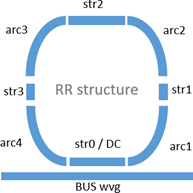

**Assessment 2.**
Define a Ring Resonator SAX model for the structure depicted in Figure 2 including:
•	A directional coupler.
•	Straight and curved waveguide segments.
•	Include parameters like coupling gap, bend radius, and the presence/absence of straight segments between bends.

**Assessment 2.1.**
Check if there is any variation of having or not straight sections between bends. How does the bend radius influence then?


In [18]:
# MODELS DEFINITION


def waveguide(wvl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    # dwl = wl - wl0
    # dneff_dwl = (ng - neff) / wl0
    # neff = neff - dwl * dneff_dwl

    phase = 2 * jnp.pi * neff * length / wvl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )
    return sdict


# Coupler Model

def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    coupler_dict = sax.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): kappa * np.exp(-1j * np.pi / 2.0),
            ("in1", "out0"): kappa * np.exp(-1j * np.pi / 2.0),
            ("in1", "out1"): tau,
        }
    )
    return coupler_dict

#def directional_coupler(gap = 0.5, length = 1.0) -> sax.SDict:
# Example model for coupling based on gap and length
#    coupling = np.exp(-gap * length * 0.05)  # Placeholder, replace with real data or fit
#    kappa = np.sqrt(coupling)
#    tau = np.sqrt(1 - coupling)
#
#    coupler_dict = sax.reciprocal(
#        {
#            ("in0", "out0"): tau,
#           ("in0", "out1"): kappa * np.exp(-1j * np.pi / 2.0),
#            ("in1", "out0"): kappa * np.exp(-1j * np.pi / 2.0),
#            ("in1", "out1"): tau,
#        }
#    )
#    return coupler_dict


def bend(wvl = 1.55, neff=2.4, radius=10, bend_loss_db_per_cm=0.1):
    # Constants
    arc_length = jnp.pi * radius / 2  # 90º arc length in micrometers
    # Bending losses per radius -> perdidas de luz al hacer los radios muy pequeños
    bend_loss = 10 ** (-bend_loss_db_per_cm * 1e-4 * arc_length / 20)
    phase_shift = 2 * np.pi * neff * arc_length / wvl

    # S-parameters
    s21 = bend_loss * np.exp(1j * phase_shift)
    s11 = 0  # Negligible reflection
    s12 = s21
    s22 = s11

    arc_dict = sax.reciprocal(
         {
            ("in0", "out0"): s21,  # Forward transmission
            ("out0", "in0"): s12,  # Reverse transmission
            ("in0", "in0"): s11,  # Reflection at port 1
            ("out0", "out0"): s22,  # Reflection at port 2
        }

    )
    return arc_dict

In [20]:
ring_resonator, info = sax.circuit(
    netlist={
        "instances": {
            "dc_0": "coupler",
            "str3": "straight_waveguide:3",
            "str0": "straight_waveguide_0",
            "str1": "straight_waveguide_1",
            "str2": "straight_waveguide_2",
            "arc1": "bend_waveguide_1",
            "arc2": "bend_waveguide_2",
            "arc3": "bend_waveguide_3",
            "arc4": "bend_waveguide_4",
        },
        "connections": {
            "dc_0, out1": "str0, in0",
            "str0, out0": "arc1, in0",
            "arc1, out0": "str1, in0",
            "str1, out0": "arc2, in0",
            "arc2, out0": "str2, in0",
            "str2, out0": "arc3, in0",
            "arc3, out0": "str3, in0",
            "str3, out0": "arc4, in0",
            "arc4, out0": "dc_0, in1",
        },
        "ports": {
            "in0": "dc_0, in0",
            "out0": "dc_0, out0"
        },
    },
    models={
        "coupler": coupler,
        "straight_waveguide_0": waveguide,
        "straight_waveguide_1": waveguide,
        "straight_waveguide_2": waveguide,
        "straight_waveguide_3": waveguide,
        "bend_waveguide_1": bend,
        "bend_waveguide_2": bend,
        "bend_waveguide_3": bend,
        "bend_waveguide_4": bend,
    },

)

StopIteration: 

**Assessment 3.**
Design a narrowband optical filter based on a RR with an 𝐹𝑆𝑅_𝜆0 = 14 𝑛𝑚 for a SOI cross-section of 450 nm x 220 nm (W x H). Compare the response obtained from both models (SAX model and formulation model) to verify the results.
*Import the attached .txt file to get the corresponding neff and wvl data.   

